<a href="https://colab.research.google.com/github/kworathur/CV-Capstone/blob/main/brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"keshavworathur","key":"525a7f6c30bb7e288d40bf6600c4074c"}'}

# Install Python packages and download dataset

In [2]:
!pip install tensorflow
!pip install mat73
!pip install hdf5storage
!pip install opencv-python
!pip install gdown
!pip install -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

# Create the directories for original data
!rm -rf ./dataset/
!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset
!unzip figshare-brain-tumor-dataset.zip > /dev/null



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.9 MB/s eta 0:00:00
 99% 831M/839M [00:10<00:00, 54.1MB/s]
100% 839M/839M [00:10<00:00, 84.4MB/s]


In [3]:
# Download helper script hosted in google drive
!gdown https://drive.google.com/uc?id=1RFcC9qAiBl5Bv07wRD6HGRk_BBi1lU98

Downloading...
From: https://drive.google.com/uc?id=1RFcC9qAiBl5Bv07wRD6HGRk_BBi1lU98
To: /content/matlab_to_numpy.py
100% 3.04k/3.04k [00:00<00:00, 5.95MB/s]


In [4]:
%run -i 'matlab_to_numpy.py' ./dataset/

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy, patient_ids saved in ./dataset/


# Import Python Modules

In [8]:
import os
from PIL import Image
from mat73 import loadmat

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# to perform subject-wise cross validation
from sklearn.model_selection import GroupKFold
import cv2

In [ ]:
#

# Data Visualization




*   Class distribution
*   2D images with tumor slices
*   Different types of brain tumors: glioma, meningioma, pituitary





In [9]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

## Load images, masks and labels

In [10]:
labels = np.load('./dataset/labels.npy')
images = np.load('./dataset/images.npy')
masks = np.load('./dataset/masks.npy')
patient_ids = np.load('./dataset/patient_ids.npy').flatten()
file_paths = np.load('./dataset/file_paths.npy')

print(labels.shape)
print(images.shape)
print(masks.shape)
print(patient_ids.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)
(3064,)


## Number of examples per class

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


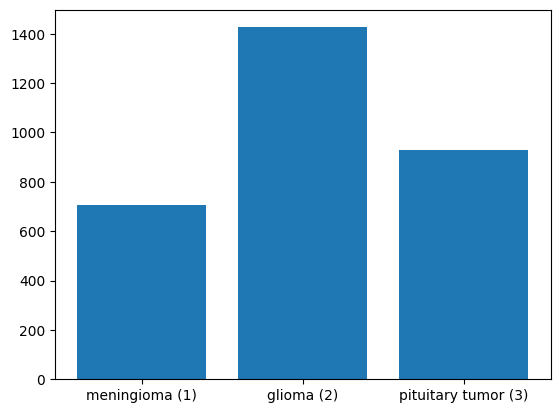

In [11]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts,
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

## Visualize slices with tumor masks

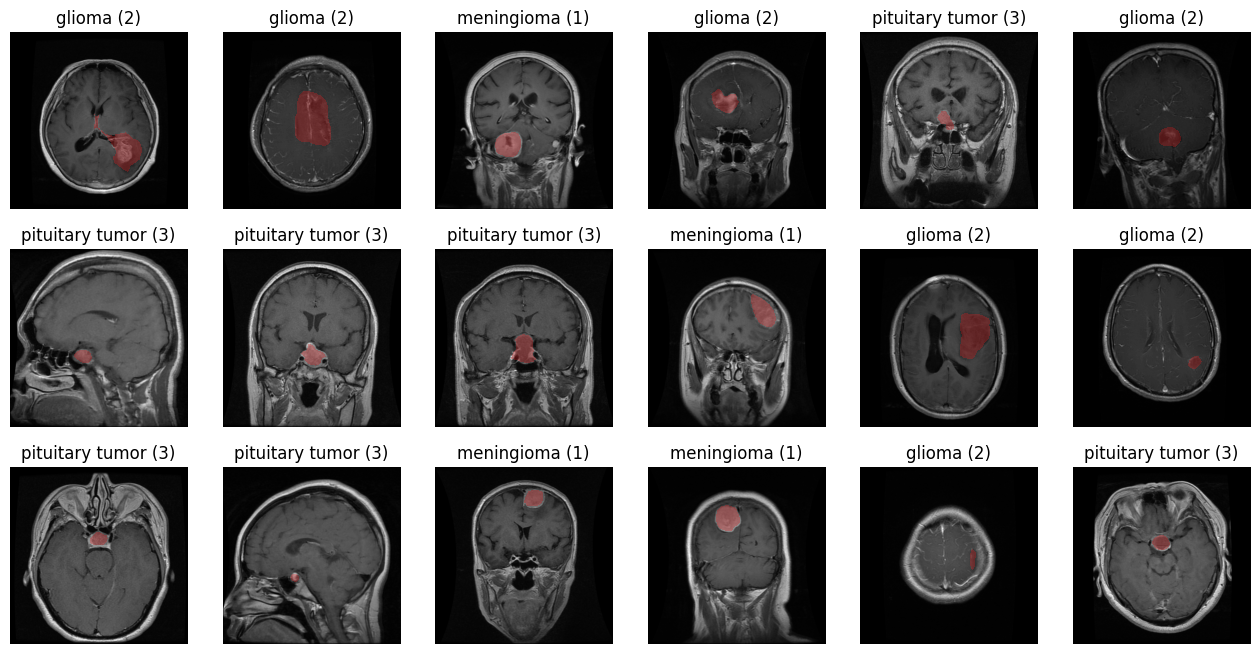

In [12]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')

    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.3, cmap='Set1')

    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

## Crop the images to the tumor region

In [13]:
def get_bounding_box(mask):
    """
    Return the bounding box of a mask image.
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=10):
    """
    Crop an image to the bounding by forcing a squared image as output.
    """
    x1, y1, x2, y2 =  bbox

    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])

    return image[y1:y2, x1:x2]

In [14]:
from IPython.display import display, clear_output

dim_cropped_image = 224

images_cropped = []

for i in range(images.shape[0]):
    if i % 10 == 0:
        # print the pourcentage of images processed
        clear_output(wait=True)
        display('[{}/{}] images processed: {:.1f} %'
                .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

    bbox = get_bounding_box(masks[i])
    image = crop_to_bbox(images[i], bbox, 20)
    image = cv2.resize(image, dsize=(dim_cropped_image, dim_cropped_image),
                       interpolation=cv2.INTER_CUBIC)
    images_cropped.append(image)

clear_output(wait=True)
display('[{}/{}] images processed: {:.1f} %'
        .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

'[3064/3064] images processed: 100.0 %'

In [23]:
images_cropped = np.array(images_cropped)

print(images_cropped.shape)

(3064, 224, 224)


## Visualize tumors

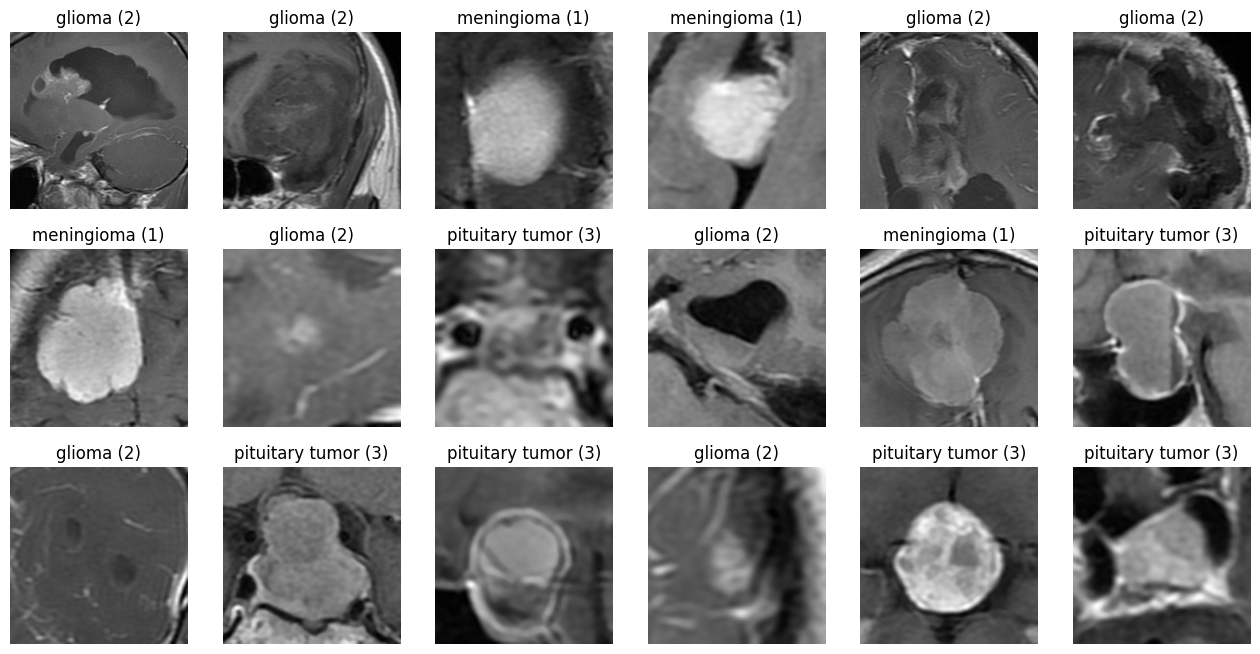

In [24]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images_cropped[idx], cmap='gray')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

### Important: Clear variables to leave sufficient free space in RAM

# Splitting the data using subject-wise cross validation

In [56]:
# 10 fold cross validation. 6 folds used for training, 2 for validation, 2 for testing
group_kfold = GroupKFold(n_splits=10)


print("Shapes")
print(f"Images {images.shape}")

folds = [indices for (_, indices) in group_kfold.split(file_paths, labels, patient_ids)]

# 6 training, 2 validation, 2 test
train_indices, val_indices, test_indices = np.concatenate(folds[0:6]), np.concatenate(folds[6:8]), np.concatenate(folds[8:10])
train_ds = tf.data.Dataset.from_tensor_slices((file_paths[train_indices], labels[train_indices]))
val_ds = tf.data.Dataset.from_tensor_slices((file_paths[val_indices], labels[val_indices]))
test_ds = tf.data.Dataset.from_tensor_slices((file_paths[test_indices], labels[test_indices]))

train_ds.element_spec

Shapes
Images (3064, 512, 512)


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [57]:
# Exact pre-processing steps: normalize and resize
img_shape=(512, 512)

resize_and_rescale = tf.keras.Sequential([
    keras.layers.Resizing(256, 256),
    keras.layers.Rescaling(1./255)
])



def read_image(path):
  path_str = path.numpy().decode('UTF-8')
  image_data = images[np.where(file_paths == path_str)].reshape(img_shape)
  print("Image ", image_data.shape)
  tensor = tf.convert_to_tensor(image_data)
  return tensor


train_ds = train_ds.map(lambda x, y: (tf.py_function(read_image, [x], [tf.int16]), y))
train_ds = train_ds.map(lambda x, y: (tf.reshape(x, (512, 512, 1)), y))

train_ds.element_spec

# val_ds = val_ds.map(lambda x, y: (read_image(x), y))
# test_ds = test_ds.map(lambda x, y: (read_image(x), y))




(TensorSpec(shape=(512, 512, 1), dtype=tf.int16, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [58]:
# Configure dataset for performance
batch_size = 16
buffer_size= 20


def prepare(ds, shuffle=False, augment=False):

  i = 0
  def augment(img):
    nonlocal i

    if i >= 2 * len(train_indices):
      image = tf.image.rot90(img)
    elif i >= len(train_indices):
      image = tf.image.flip_up_down(img)

    i += 1
    return img

  if augment:
    ds = ds.repeat(3)
    ds = ds.map(lambda x, y: (augment(x), y))

  if shuffle:
    ds = ds.shuffle(buffer_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size)
  return ds

train_ds = prepare(train_ds, shuffle=True, augment=True)


for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)





Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
(16, 512, 512, 1)
(16,)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
Image  (512, 512)
(16, 512, 512, 1)
(16,

UnknownError: ignored

In [ ]:

model = keras.Sequential()

### Pre-Processing Layer ###
model.add(keras.Input(shape=(512, 512, 1)))
model.add(keras.layers.Resizing(256, 256))
model.add(keras.layers.Rescaling(1./255))
model.summary()


### Classification Block A ###
model.add(keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_18 (Resizing)      (256, 256, 512)           0         
                                                                 
 rescaling_18 (Rescaling)    (256, 256, 512)           0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ValueError: ignored